In [1]:
import pandas as pd
from datetime import datetime
from astropy.time import Time
import matplotlib.pyplot as plt
from myutils import data_utils as du

# Data

### TNS classifications within time-range of experiment

In [2]:
# read TNS labels and apply timeranges for this experiment
df_tns_w_ztfdata = du.load_TNS_Fink('../classifications/tns_fink_20230817.parquet')

# classified by ZTF
ztf_tns = df_tns_w_ztfdata[df_tns_w_ztfdata['reporting_group']=='ZTF']
print(f"ZTF detected and spectroscopically classified {len(ztf_tns)}")


ZTF detected and spectroscopically classified 243


### BEWARE!
Not all detected by ZTF will enter in our AL loop (with valid features), so we need to filter them. This will be analysed further below, meanwhile leats take a look of the TNS classifications

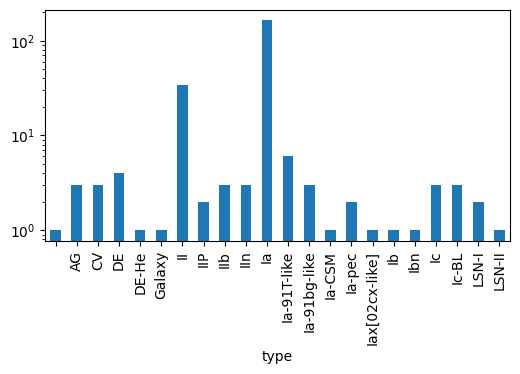

In [41]:
fig = plt.figure(figsize=(6, 3))
ztf_tns.groupby('type').size().plot(kind='bar')
plt.yscale('log')


### Fink Siding Spring Observatory follow-up 
Fink programme to acquire labels for those candidates around P_Ia ~0.5

In [43]:
# read labels
df_Fink_AL = pd.read_csv('../classifications/ALbot_with_classifications_curated.tsv', sep='\t')

df_Fink_AL['bot_jd'] = [Time(datetime.strptime(d[0], '%d/%m/%Y')).jd for d in df_Fink_AL[['Appears in bot']].values]
df_Fink_AL['tmp'] = [datetime.strptime(d[0], '%d/%m/%Y') for d in df_Fink_AL[['Appears in bot']].values]
df_Fink_AL['fup_jd_strfmt'] = df_Fink_AL.loc[:,'tmp'].apply(lambda x: du.add_days_and_format(Time(x), 1))

# some of the Fink AL identified objects might have been classified by another group and reported to TNS
print(f"Adding {len(df_Fink_AL[df_Fink_AL['ztf_names'].isin(df_tns_w_ztfdata['ztf_names']) & df_Fink_AL['Classification'].isna()])} \
      classifications from TNS to Fink AL")

# Merge df1 with df2 on 'ztf_names' to fill in the missing Classification
df_merged = pd.merge(df_Fink_AL, df_tns_w_ztfdata, how='left', on='ztf_names')

# Rename the 'type' column to 'Classification' in the merged DataFrame
df_merged['Classification'] = df_merged.apply(lambda row: row.type if row.Classification is None else row.Classification, axis=1)

# Drop the 'type' column since it's now renamed
df_merged = df_merged.drop(columns=['type'])

df_Fink_AL_w_classifications = df_merged[df_merged['Classification'].notna()]
# reformat type for AL loop
df_Fink_AL_w_classifications['type AL'] = df_Fink_AL_w_classifications.loc[:,'Classification'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')


Adding 3       classifications from TNS to Fink AL


/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_10501/4186230373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Fink_AL_w_classifications['type AL'] = df_Fink_AL_w_classifications.loc[:,'Classification'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')


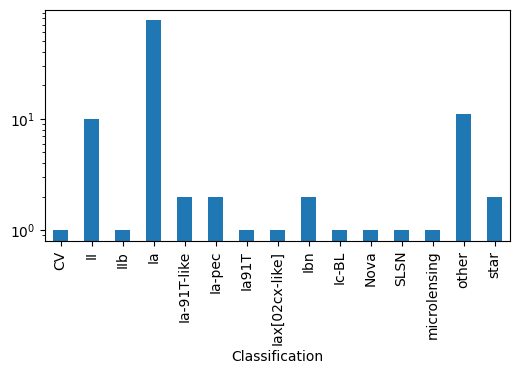

In [44]:
fig = plt.figure(figsize=(6, 3))
df_Fink_AL_w_classifications.groupby('Classification').size().plot(kind='bar')
plt.yscale('log')


<Axes: xlabel='type AL'>

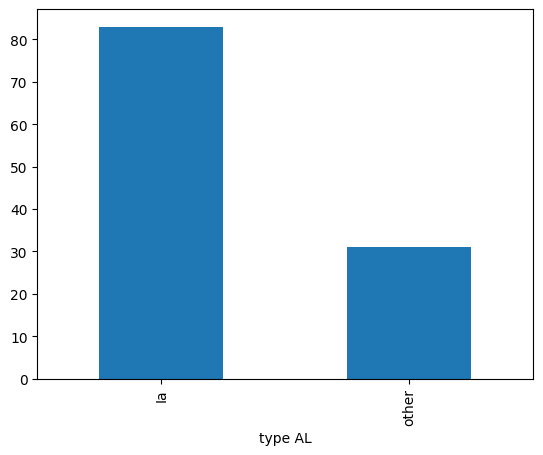

In [45]:
df_Fink_AL_w_classifications.groupby(['type AL']).size().plot(kind='bar')